In [1]:
import pickle
import numpy as np
from scipy.special import logsumexp

import matplotlib.pyplot as plt
import seaborn as sns

import scipy

In [2]:
# generate binary input vector
def simulate_single_input(time, Dv):
    inputs = np.zeros((time, Dv))
    if Dv > 0:
    
        number_of_non_zero_dimenions = np.random.choice(np.arange(3,8), 1)[0]

        non_zero_dimensions = np.random.choice(Dv - 1, number_of_non_zero_dimenions, replace=False)

        for k in non_zero_dimensions:
            start = np.random.choice(time - 1, 1)[0]
            end = start + 1 + np.random.choice(np.arange(40, 60),1)[0]
            end = min(end, time)
            inputs[start:end, k] = np.ones(end-start)

        # surgery is at the last axis
        start = np.random.randint(int(0.3 * time), int(0.6 * time))
        end = time
        inputs[start:end, -1] = np.ones(end-start)
    
    return inputs

In [3]:
def simulate_clv_with_inputs(A, g, Wg, f_cov, N, inputs):
    #  Wg: (Dx, Dv), W1 (Dx, Dv), W2 (1, Dx+1)
    # x_t + g_t + Wg v_t + (A+ A(v_t)) * p_t where A(v_t) = (W1 * vt) * W2
    latent_dim = A.shape[0]
    ndays, input_dim = inputs.shape
    x = []
    y_count = []
    y_percentage = []

    # modify the mu
    mu = np.random.multivariate_normal(mean=np.zeros(latent_dim), cov=np.eye(latent_dim))
    for t in range(ndays):
        xt = mu

        # increase dimension by 1
        xt1 = np.concatenate((xt, np.array([0])))
        pt = np.exp(xt1 - logsumexp(xt1))

        # simulate total number of reads with over-dispersion
        logN = np.random.normal(loc=np.log(N), scale=0.5)
        Nt = np.random.poisson(np.exp(logN))

        yt_count = np.random.multinomial(Nt, pt).astype(float)
        yt_percentage = yt_count / np.sum(yt_count)

        x.append(xt)
        y_count.append(yt_count)
        y_percentage.append(yt_percentage)

        transition_noise = np.random.multivariate_normal(mean=np.zeros(latent_dim), cov=np.diag(f_cov))
        vt = inputs[t]

        mu = xt + g + Wg.dot(vt) + A.dot(pt) # + transition_noise
        # mu = np.clip(mu, -3, 3)

    return np.array(x), np.array(y_count), np.array(y_percentage)

In [4]:
ntaxa = 11
ninput = 0  # including surgery
n_train, n_test = 200, 30
time_min = 40
time_max = 50
scale = 4
simulation_time = time_max * scale
obs_percentage = 0.2

# interaction
A  = np.random.normal(loc=0, scale=0.03, size=(ntaxa, ntaxa))
for i in range(ntaxa):
    A[i, i] = -np.abs(A[i, i])
    for j in range(i + 1, ntaxa):
        A[i, j] = -np.sign(A[j, i]) * np.abs(A[i, j])

# inputs
Wg = np.random.normal(loc=0, scale=0.02, size=(ntaxa, ninput))
if ninput > 0:
    Wg[:, -1] = -np.abs(Wg[:, -1])
for i in range(ninput - 1):
    n_zero_items = int(ntaxa * 0.75)
    idxs = np.random.choice(np.arange(ntaxa), n_zero_items, replace=False)
    Wg[idxs, i] = np.zeros_like(idxs)

g = np.random.gamma(shape=1.1, scale=0.01, size=(ntaxa,))
f_cov = np.random.gamma(shape=1.2, scale=0.05, size=(ntaxa - 1,))
N = 10000 # sequencing reads parameter

print("A\n" + "\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in A]))
print("g\n" + " ".join(["{:>5.3f}".format(ele) for ele in g]))
print("Wg\n" + "\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in Wg]))
print("f_cov\n" + " ".join(["{:>5.3f}".format(ele) for ele in f_cov]))

A = A[:-1] - A[-1:]
g = g[:-1] - g[-1:]
Wg = Wg[:-1] - Wg[-1:]

A
-0.01 -0.06 -0.03 -0.06 -0.01 -0.01  0.06  0.03 -0.06 -0.01  0.05
 0.03 -0.02  0.05 -0.06 -0.01 -0.02 -0.08  0.00 -0.02 -0.00  0.02
 0.03 -0.00 -0.03  0.02 -0.02  0.02 -0.00  0.00  0.03  0.08  0.03
 0.07  0.01 -0.03 -0.07 -0.01 -0.05  0.01 -0.03 -0.00 -0.01 -0.02
 0.02  0.03  0.04  0.02 -0.00  0.00  0.00 -0.00  0.06  0.01 -0.04
 0.02  0.01 -0.03  0.01 -0.03 -0.00 -0.04 -0.04 -0.01 -0.02 -0.04
-0.00  0.04  0.03 -0.01 -0.01  0.00 -0.01 -0.01 -0.04 -0.01 -0.01
-0.03 -0.01 -0.02  0.04  0.03  0.03  0.03 -0.04 -0.00  0.05 -0.02
 0.00  0.03 -0.03  0.04 -0.01  0.02  0.03  0.00 -0.04  0.02 -0.01
 0.06  0.02 -0.05  0.01 -0.05  0.05  0.03 -0.04 -0.02 -0.01 -0.07
-0.04 -0.03 -0.00  0.03  0.02  0.03  0.05  0.03  0.02  0.01 -0.03
g
0.005 0.001 0.007 0.027 0.026 0.007 0.021 0.015 0.011 0.035 0.009
Wg











f_cov
0.037 0.072 0.009 0.004 0.036 0.037 0.053 0.011 0.107 0.061


In [5]:
overwrite_params = False
if overwrite_params:
    with open("data/clv_count_ntrain_200_Dx_10_obs_10_noinput.p", "rb") as f:
        d = pickle.load(f)
    A = d["A"]
    g = d["g"]
    Wg = d["Wg"]
    f_cov = d["f_cov"]
    N = d["N"]

In [6]:
# create data with missing observation
x_train = []
x_test = []
y_count_train = []
y_count_test = []
y_percentage_train = []
y_percentage_test = []
v_train = []
v_test = []

batch_inputs = [simulate_single_input(simulation_time, ninput) for _ in range(n_train + n_test)]

for i in range(n_train + n_test):
    v = batch_inputs[i]  # (time, Dv)
    x, y_count, y_percentage = simulate_clv_with_inputs(A, g, Wg, f_cov, N, v)

    idx = np.arange(time_max) * scale
    ndays = np.random.randint(time_min, time_max)
    start = np.random.randint(time_max - ndays)
    idx = idx[start:start + ndays]
    
    x = x[idx]
    y_count = y_count[idx]
    y_percentage = y_percentage[idx]
    v = v[idx]
    
    # make missing observations, the first day cannot be missing
    if int(ndays * obs_percentage) == ndays:
        obsed_days = np.arange(ndays)
    else:
        obsed_days = np.random.choice(np.arange(1, ndays), int(ndays * obs_percentage), replace=False)
        obsed_days = np.sort(np.concatenate(([0],obsed_days)))
    
    y_percentage = y_percentage[obsed_days]
    x = x[obsed_days]
    y_count = y_count[obsed_days]
    
    days = np.arange(ndays)[:, np.newaxis]
    y_count = np.concatenate([days[obsed_days], y_count], axis=-1)
    y_percentage = np.concatenate([days[obsed_days], y_percentage], axis=-1)
    v = np.concatenate([days, v], axis=-1)
    
    if i < n_train:
        x_train.append(x)
        y_count_train.append(y_count)
        y_percentage_train.append(y_percentage)
        v_train.append(v)
    else:
        x_test.append(x)
        y_count_test.append(y_count)
        y_percentage_test.append(y_percentage)
        v_test.append(v)

In [7]:
counts_train = []
for single_obs in y_count_train:
    single_counts = single_obs[:,1:].sum(axis=-1)
    counts_train.append(single_counts)
    
counts_test = []
for single_obs in y_count_test:
    single_counts = single_obs[:,1:].sum(axis=-1)
    counts_test.append(single_counts)

In [8]:
p_data = {}
p_data["Xtrain"] = x_train
p_data["Xtest"] = x_test
p_data["Ytrain"] = y_percentage_train
p_data["Ytest"] = y_percentage_test
p_data["Vtrain"] = v_train
p_data["Vtest"] = v_test

p_data["A"] = A
p_data["g"] = g
p_data["Wg"] = Wg
p_data["f_cov"] = f_cov
p_data["N"] = N
# with open("data/clv_ntrain_{}_Dx_{}.p".format(n_train, ntaxa - 1), "wb") as f:
#     pickle.dump(p_data, f)

In [9]:
c_data = {}
c_data["Xtrain"] = x_train
c_data["Xtest"] = x_test
c_data["Ytrain"] = y_count_train
c_data["Ytest"] = y_count_test
c_data["Vtrain"] = v_train
c_data["Vtest"] = v_test
c_data["counts_train"] = counts_train
c_data["counts_test"] = counts_test

c_data["A"] = A
c_data["g"] = g
c_data["Wg"] = Wg
c_data["f_cov"] = f_cov
c_data["N"] = N
with open("data/clv_count_ntrain_{}_Dx_{}_obs_{:02d}_noinput.p".format(n_train, ntaxa - 1, int(obs_percentage * 10)), "wb") as f:
    pickle.dump(c_data, f)

# visualize the data

In [10]:
import sys
sys.path.append("../..")

In [11]:
from src.utils.data_interpolation import interpolate_data

In [12]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test = x_train, x_test, y_percentage_train, y_percentage_test, v_train, v_test

In [13]:
extra_inputs_train = [None for _ in range(len(obs_train))]
extra_inputs_test = [None for _ in range(len(obs_test))]

In [14]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test, _mask_train, _mask_test, time_interval_train, time_interval_test, extra_inputs_train, extra_input_test = \
    interpolate_data(hidden_train, hidden_test, obs_train, obs_test, input_train, input_test,
                     extra_inputs_train, extra_inputs_test, interpolation_type=None)


masks = _mask_train + _mask_test
obs = obs_train + obs_test
inputs = input_train + input_test

In [15]:
# count data
c_hidden_train, c_hidden_test, c_obs_train, c_obs_test, c_input_train, c_input_test, c_extra_inputs_train, c_extra_inputs_test = x_train, x_test, y_count_train, y_count_test, v_train, v_test, counts_train, counts_test

In [16]:
c_hidden_train, c_hidden_test, c_obs_train, c_obs_test, c_input_train, c_input_test, c_mask_train, c_mask_test, time_interval_train, time_interval_test, c_extra_inputs_train, c_extra_input_test = \
                interpolate_data(c_hidden_train, c_hidden_test, c_obs_train, c_obs_test, c_input_train, c_input_test,
                                 c_extra_inputs_train, c_extra_inputs_test)


c_masks = c_mask_train + c_mask_test
c_obs = c_obs_train + c_obs_test
c_inputs = c_input_train + c_input_test

In [17]:
def bar_plot(ax, obs, mask, to_normalize=True):
    if to_normalize:
            obs = obs / np.sum(obs, axis=-1, keepdims=True)

    time, Dy = obs.shape

    # make missing obs = 0
    masked_obs = np.zeros_like(obs)
    masked_obs[mask] = obs[mask]
    
    ax.set_xlabel("Time")
    bottom = np.zeros(time)
    for j in range(Dy):
        ax.bar(np.arange(time), masked_obs[:, j], bottom=bottom, edgecolor='white')
        bottom += masked_obs[:, j]

    ax.set_xticks(np.arange(time))
    sns.despine()
    

def input_plot(ax, inputs):
    time, Dv = inputs.shape
    
    for j in range(Dv):
        has_inputs = inputs[:,j]== 1
        idx = np.arange(time)[has_inputs]
        ax.bar(idx, [1 for _ in idx], bottom=[j for _ in idx], color='blue')
    
    ax.set_xticks(np.arange(time))
    ax.set_yticks(np.arange(Dv))
    sns.despine()

In [18]:
def plot_inputs_and_obs(inputs, masks, i, to_normalize=True):
    plt.figure(figsize=(15,10))

    ax1= plt.subplot(2,1,1)
    input_plot(ax1, inputs[i])
    ax1.grid()

    ax2 = plt.subplot(2,1,2, sharex = ax1)
    bar_plot(ax2, obs[i], masks[i], to_normalize=to_normalize)
    ax2.grid()

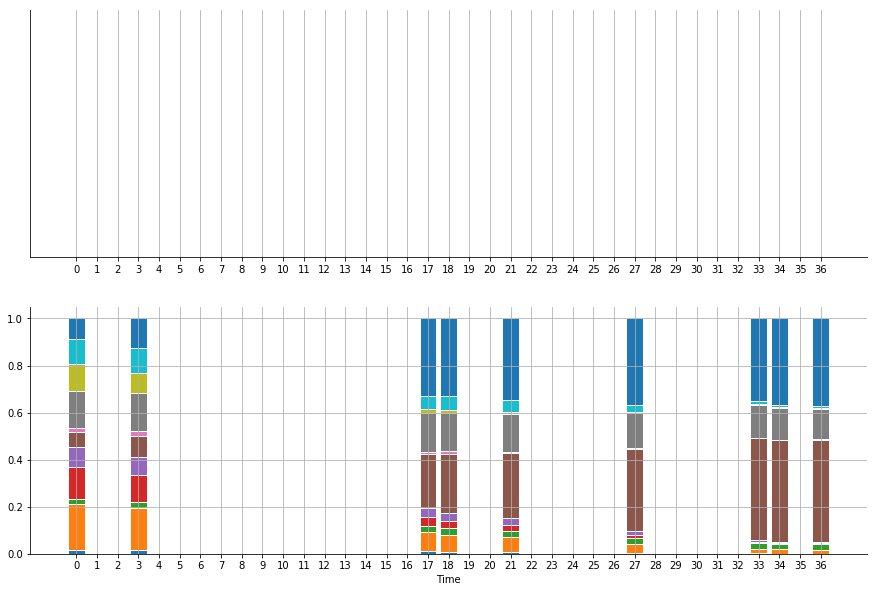

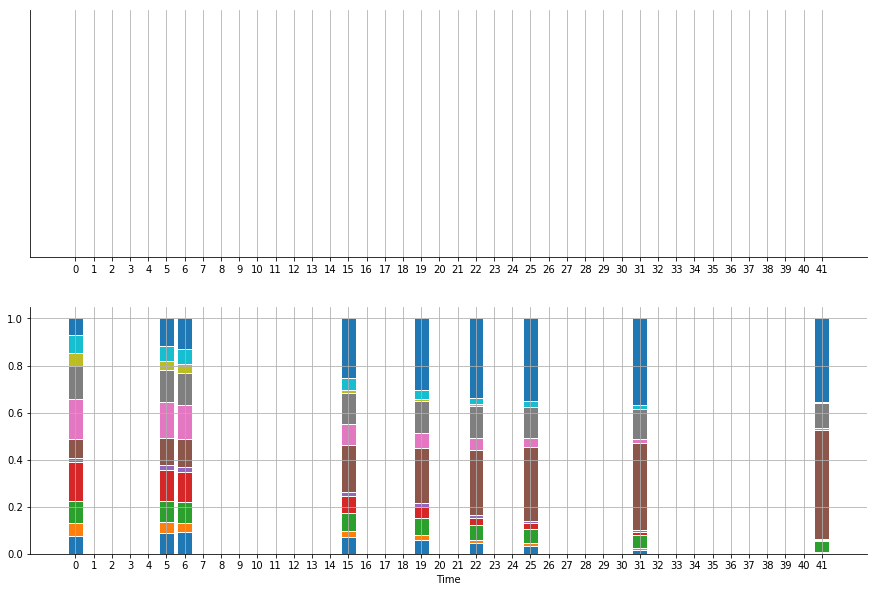

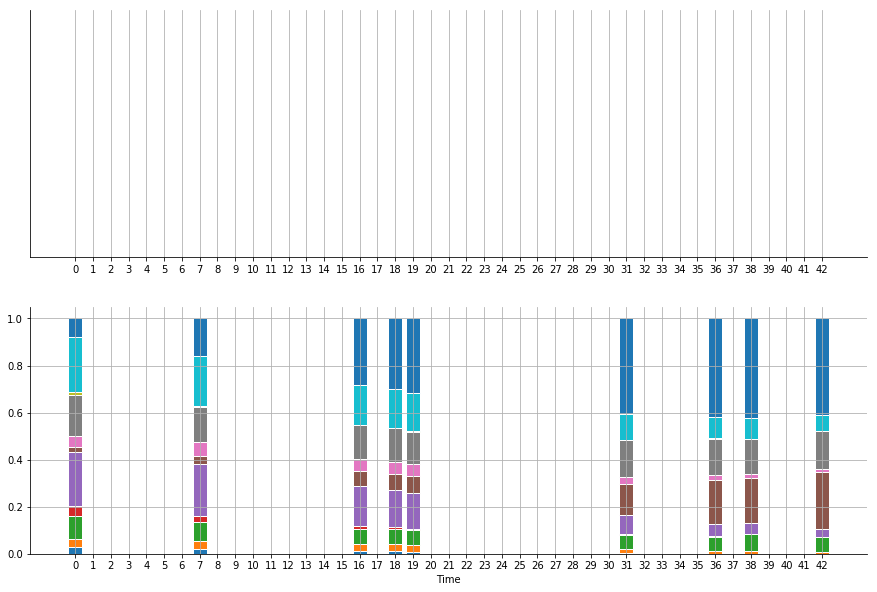

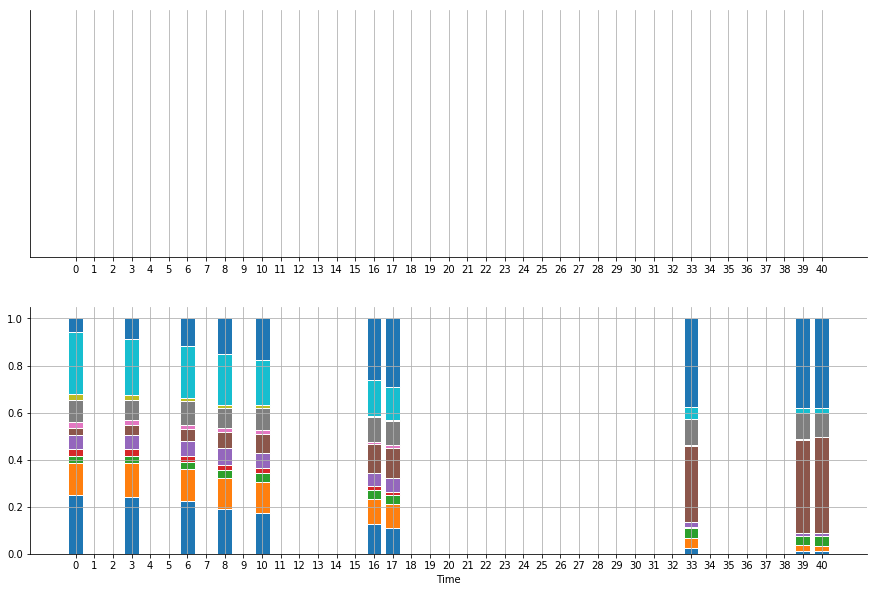

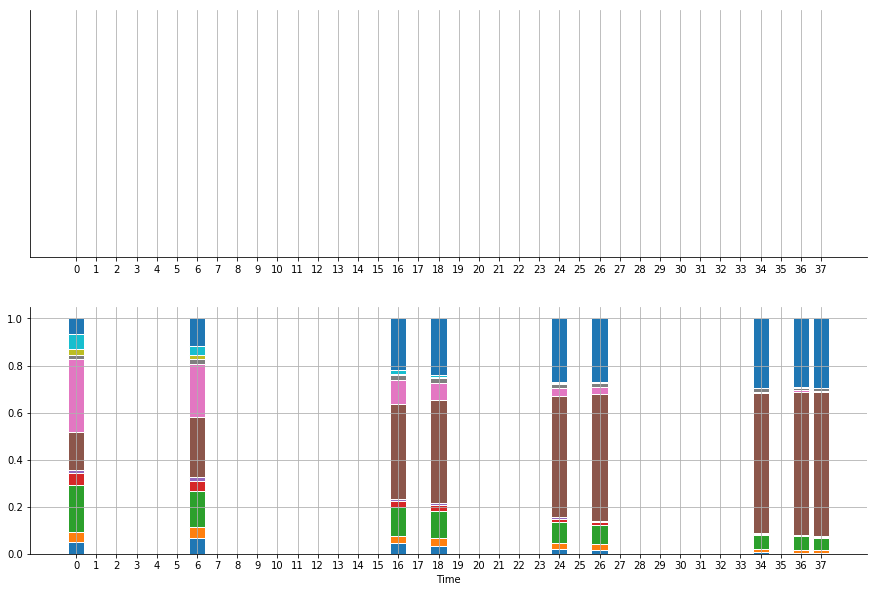

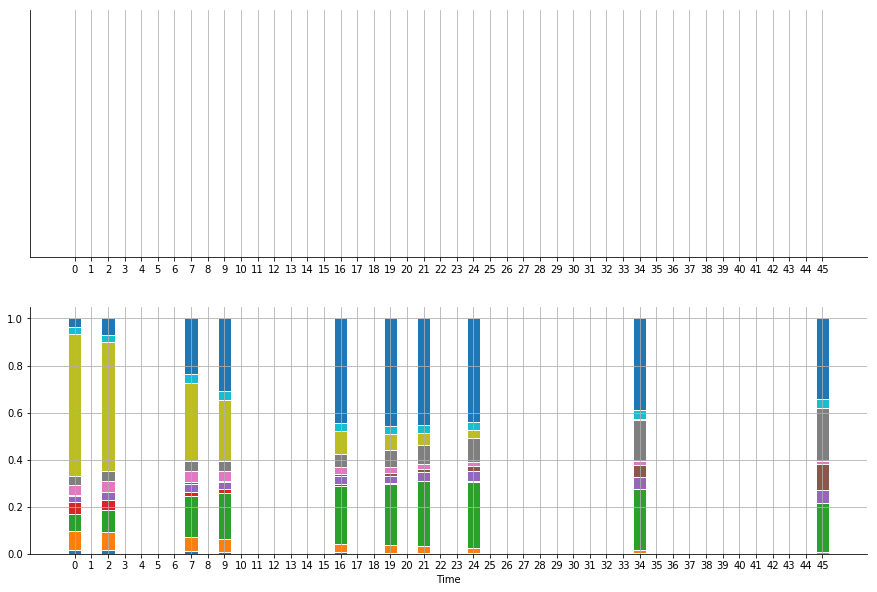

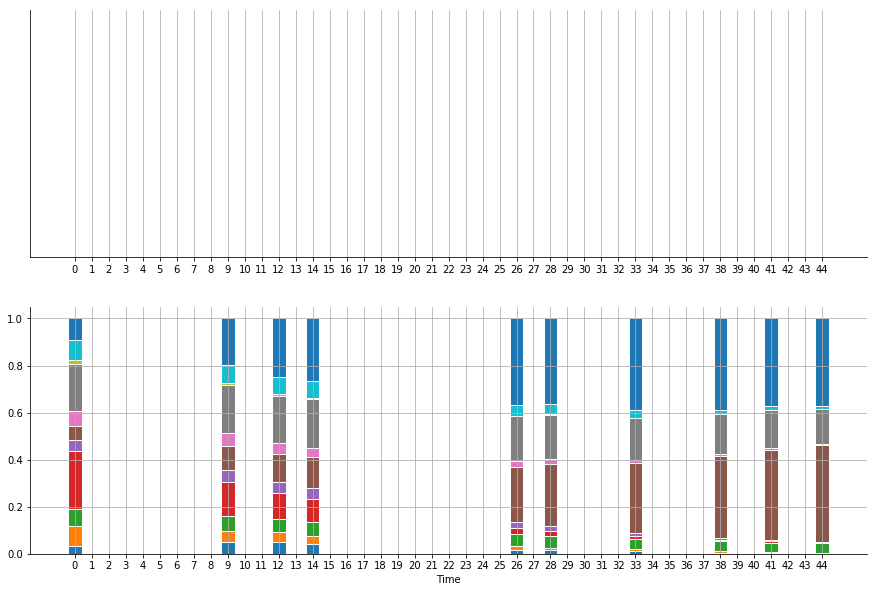

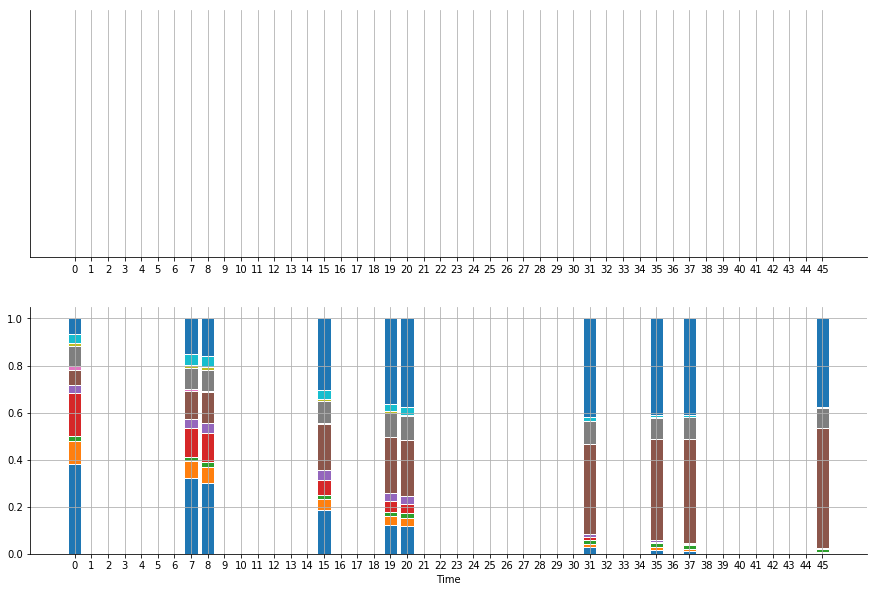

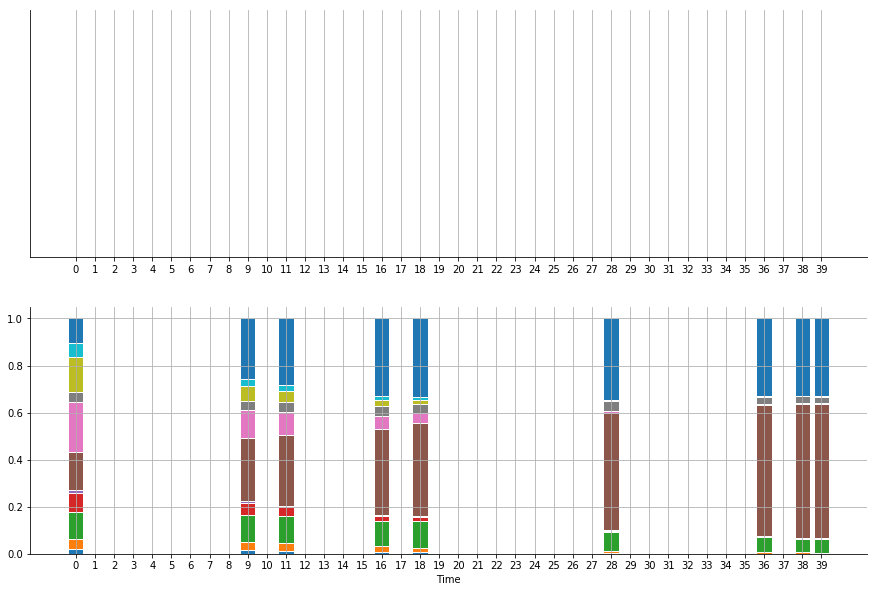

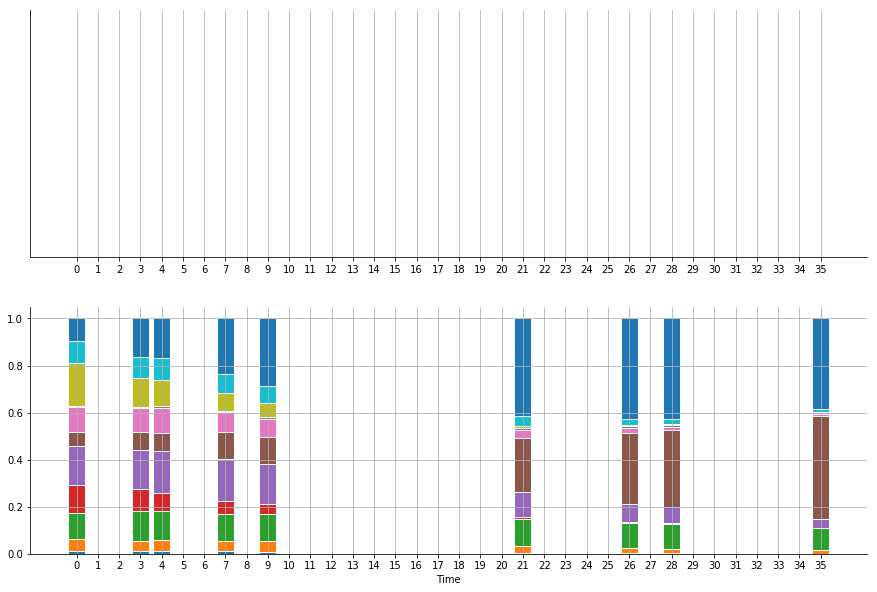

In [19]:
for i in range(10):
    plot_inputs_and_obs(inputs, masks, i)

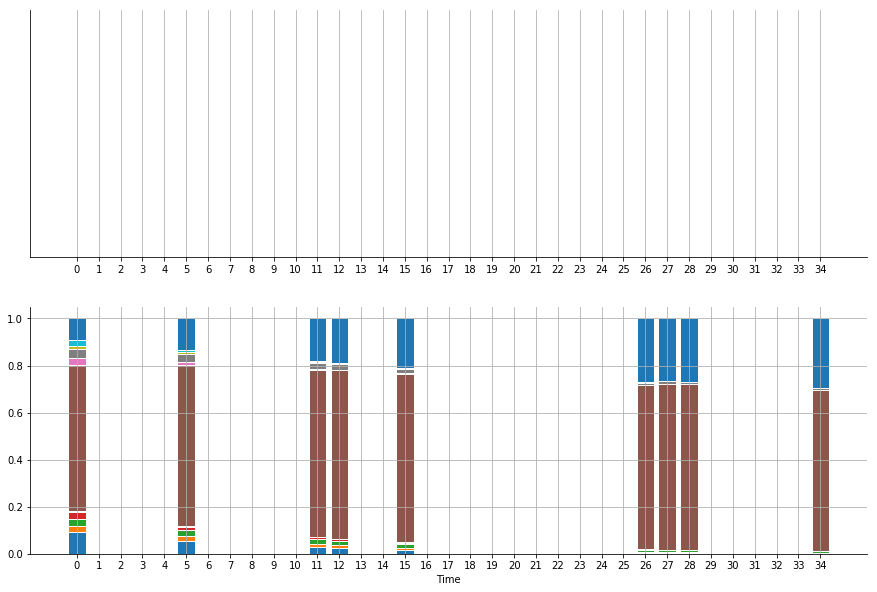

In [20]:
plot_inputs_and_obs(c_inputs, c_masks, 10, to_normalize=True)